In [8]:
from src.sar_transformer.utils import load_concat_transformer
from src.sar_transformer.eval import evaluate_ad_agent
from src.sar_transformer.dataset import HistoryDataset, create_history_dataloader
from src.sar_transformer.eval import evaluate_ad_agent
from src.generation import *

import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import einops
from tqdm import tqdm

import transformer_lens
from transformer_lens import utils
from transformer_lens.head_detector import *

import plotly.express as px

%matplotlib inline

In [9]:
# model = load_concat_transformer("models\dark_room_test__1000__1685416926_checkpoints\checkpoint_epoch_200.pt").to("cuda")
#model = load_concat_transformer("models\dark_room_test__1000__1686153478_checkpoints\checkpoint_epoch_300.pt").to("cuda")
model = load_concat_transformer("models/6l_darkroom.pt").to("cuda")
env_config = model.environment_config

In [10]:
model.transformer_config

TransformerModelConfig(d_model=256, n_heads=4, d_mlp=2048, d_head=64, n_layers=6, n_ctx=240, layer_norm=True, attn_only=False, state_embedding_type='linear', time_embedding_type='embedding', seed=1, device=device(type='cuda'))

In [21]:
action_buffer=[1,1,1,1,1,1]
reward_buffer=[1,1,1,1,1,1]
timesteps=[0,1,2,3,4,5]

In [37]:
env=env_config.env
state_buffer = np.zeros((1, 1, 12))
obs=env.reset()
state_buffer[0, 0] = obs
for action in action_buffer:
    obs, _, _, _, _ = env.step(action)
    state_buffer.append(obs) 

(1, 240, 12)

In [ ]:
obs, _ = env.reset()
current_timestep = 0
    

In [48]:
state_buffer[0][230]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
states = torch.as_tensor(state_buffer, dtype=torch.double, device=model.transformer_config.device)
actions = torch.as_tensor(action_buffer, dtype=torch.long, device=model.transformer_config.device)
rewards = torch.as_tensor(reward_buffer, dtype=torch.double, device=model.transformer_config.device)
timesteps = torch.as_tensor(timesteps, dtype=torch.long, device=model.transformer_config.device)
               

In [32]:
embeddings = model.to_tokens(
                states=states,
                actions=actions,
                rewards=rewards,
                timesteps=timesteps,
            )

AssertionError: 

In [ ]:
_, cache = model.transformer.run_with_cache(embeddings)

### Setup Head Detection


### Interpretability Experiments

How can we figure out what internal circuits best explain model performance

 - train supervised probes and check what features they look for
 - Use head_detector to find heads that look for previous observations

EVAL  - Random walk score: 1.7950, Optimal score: 7.4750, AD high score: 6.4000, AD final score: 6.4000: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


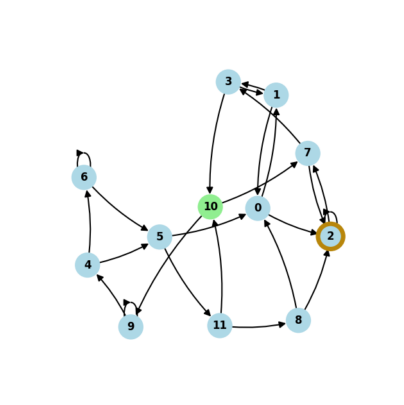

In [54]:
state_buffer, action_buffer, reward_buffer, embeddings, cache = evaluate_ad_agent(model, env_config, 10, return_cache=True)
plt.figure(figsize = (5, 5))
plt.imshow(env_config.env.render(), interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
env_config.env.reward_rules

[[11, -1, 1, 1.0, 1.0, -1]]

In [13]:
def display_head(cache, labels, layer, head, n_episodes=3):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    matrix = average_patterns[0, head, :24*n_episodes, :24*n_episodes].cpu()
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)

    fig.show()

    

In [14]:
def display_head(cache, labels, layer, head, n_episodes=3):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    matrix = average_patterns[0, head, :24*n_episodes, :24*n_episodes].cpu()
    fig = px.imshow(
        matrix,
        labels=dict(x="AttendedPos", y="CurrentPos", color="Value"),
    )
    layout = dict(
        width=800,
        height=800,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels,
        )
    )
    fig.update_layout(layout)

    fig.show()


In [15]:
display_head(cache, labels, 2, 0, 3)